# After the loading and inital exploration, let's analyze the data

# 1. Import libraries

In [1]:
# ======================================================
# 1. Import libraries
# ======================================================
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# 2. Functions

In [2]:
# ======================================================
# 2. Functions
# ======================================================

def load_city_data(city, temp_dir, wind_dir):
    tx = pd.read_csv(
        f"{temp_dir}{city}_daily_TX_raw.csv",
        parse_dates=["date"]
    )
    wind = pd.read_csv(
        f"{wind_dir}temp_wind_{city.lower()}.csv",
        parse_dates=["date"]
    )
    tx["date"] = pd.to_datetime(tx["date"])
    wind["date"] = pd.to_datetime(wind["date"])
    wind = wind.drop_duplicates(subset=["date", "NUM_POSTE"])

    df_final = pd.merge(
        tx,
        wind,
        on=["date", "NUM_POSTE"],
        how="inner",
        suffixes=("_tx", "_wind")
    )
    return df_final.sort_values(["NUM_POSTE", "date"]).reset_index(drop=True)
    
    # 6) Convert to dataframe and sort
    results_df = pd.DataFrame(results).sort_values("matching_days", ascending=False)
    print(results_df)
    print(f"\nBest station: {results_df.iloc[0]['NOM_USUEL']}")

    tx_best_station = tx[tx['NUM_POSTE'] == results_df.iloc[0]['NUM_POSTE']]
  
    return (
        tx_best_station.merge(wind, on="date", how="inner")
          .sort_values("date")
          .reset_index(drop=True)
    )

# 3. Load data (Marseille)

In [3]:
# ======================================================
# 3. Load data
# ======================================================
CITY = "Marseille" # Marseille, Lyon, Paris or Bordeaux
TEMP_DIR = "../data/1_outputs/"
WIND_DIR = "../data/2_outputs/"

df_marseille = load_city_data(CITY, TEMP_DIR, WIND_DIR)

df_marseille.head()

,date,NUM_POSTE,NOM_USUEL_tx,TX,TN,LAT,LON,ALTI,NOM_USUEL_wind,temp_mean_c,temp_max_c,wind_mean_10m_ms,wind_mean_2m_ms,wind_max_hourly_ms,wind_max_inst_ms,wind_gust_3s_ms,wind_dir_max_deg,wind_dir_inst_deg,city
0,1955-07-01,13001009,AIX EN PROVENCE,28.0,11.7,43.5295,5.4245,173,AIX EN PROVENCE,NaN,28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Marseille
1,1955-07-02,13001009,AIX EN PROVENCE,29.0,13.0,43.5295,5.4245,173,AIX EN PROVENCE,NaN,29.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Marseille
2,1955-07-03,13001009,AIX EN PROVENCE,28.9,19.7,43.5295,5.4245,173,AIX EN PROVENCE,NaN,28.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Marseille
3,1955-07-04,13001009,AIX EN PROVENCE,29.8,16.0,43.5295,5.4245,173,AIX EN PROVENCE,NaN,29.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Marseille
4,1955-07-05,13001009,AIX EN PROVENCE,24.1,17.4,43.5295,5.4245,173,AIX EN PROVENCE,NaN,24.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Marseille


# 4. Explore data

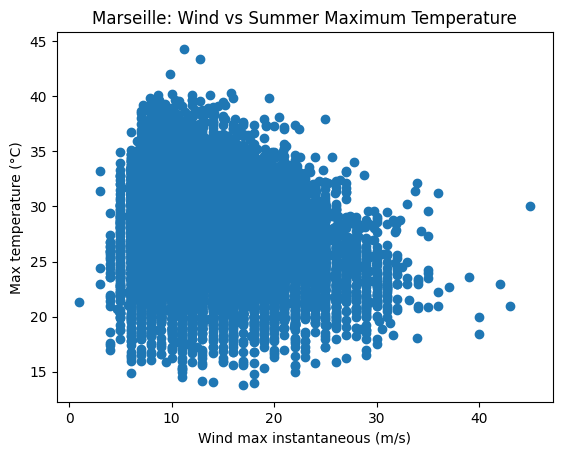

In [4]:

# ======================================================
# 4. Explore data
# ======================================================


# --- Contiue with the Marseille data ---
df = df_marseille.copy()

# Ensure datetime
df["date"] = pd.to_datetime(df["date"])
df["month"] = df["date"].dt.month

# Keep summer months (JJA)
df_summer = df[df["month"].isin([6, 7, 8])]

# --- Choose variables ---
temp_col = "TX"                 # or "temp_max_c" (pick one and be consistent)
wind_col = "wind_max_inst_ms"

# --- Scatter plot ---
plt.figure()
plt.scatter(df_summer[wind_col], df_summer[temp_col])
plt.xlabel("Wind max instantaneous (m/s)")
plt.ylabel("Max temperature (°C)")
plt.title("Marseille: Wind vs Summer Maximum Temperature")
plt.show()

# Interpretation:
# Wind speed is not linearly correlated with summer maximum temperature, 
#but it may act as a limiting factor for extreme heat and may become 
#informative when modelling heatwave occurrence or when using non-linear 
#models such as Random Forests, decision trees, or gradient boosting.

# 5. Find heatwaves

In [5]:

# ======================================================
# 5. Find heatwaves
# ======================================================


df = df_marseille.copy()
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").reset_index(drop=True)

TX_P95 = df["TX"].quantile(0.95)
TX_THRESHHOLD = 35
df["hot_day"] = df["TX"] >= TX_THRESHHOLD

# Explicit consecutive-day counter
df["hot_spell_len"] = 0
count = 0

df["hot_spell_len"] = df.groupby((df["hot_day"] != df["hot_day"].shift()).cumsum())["hot_day"].cumsum() * df["hot_day"]

#for i, is_hot in enumerate(df["hot_day"]):
#    if is_hot:
#        count += 1
#    else:
#        count = 0
#    df.loc[i, "hot_spell_len"] = count

# Heatwave tags: date are greater than or equal to (ge) 3 days.
df["heatwave_ge_3days"] = df["hot_spell_len"] >= 3
df["heatwave_gt_3days"] = df["hot_spell_len"] > 3

print(df['hot_spell_len'].sum())
print(TX_P95)

1672
31.5


# 6. Summer analysis: wind vs temperature with heatwaves

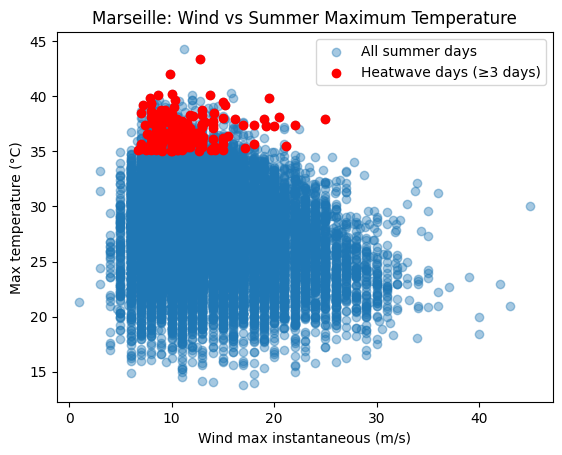

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134963 entries, 0 to 134962
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date                134963 non-null  datetime64[ns]
 1   NUM_POSTE           134963 non-null  int64         
 2   NOM_USUEL_tx        134963 non-null  object        
 3   TX                  130931 non-null  float64       
 4   TN                  130931 non-null  float64       
 5   LAT                 134963 non-null  float64       
 6   LON                 134963 non-null  float64       
 7   ALTI                134963 non-null  int64         
 8   NOM_USUEL_wind      134963 non-null  object        
 9   temp_mean_c         97367 non-null   float64       
 10  temp_max_c          130931 non-null  float64       
 11  wind_mean_10m_ms    113203 non-null  float64       
 12  wind_mean_2m_ms     0 non-null       float64       
 13  wind_max_hourly_ms  80480 non

None

In [6]:
# ======================================================
# 6. Summer analysis: wind vs temperature with heatwaves
# ======================================================



# Recreate summer subset AFTER heatwave tags exist
df["month"] = df["date"].dt.month
df_summer = df[df["month"].isin([6, 7, 8])]

temp_col = "TX"
wind_col = "wind_max_inst_ms"

# All summer days
plt.figure()
plt.scatter(
    df_summer[wind_col],
    df_summer[temp_col],
    alpha=0.4,
    label="All summer days"
)

# Heatwave days (≥ 3 consecutive days)
hw = df_summer[df_summer["heatwave_ge_3days"]]

plt.scatter(
    hw[wind_col],
    hw[temp_col],
    color="red",
    label="Heatwave days (≥3 days)"
)

plt.xlabel("Wind max instantaneous (m/s)")
plt.ylabel("Max temperature (°C)")
plt.title("Marseille: Wind vs Summer Maximum Temperature")
plt.legend()
plt.show()

display(df.info())

# 7. ML classification: heatwave occurrence 

wind_mean_10m_ms       5472
wind_max_hourly_ms    13765
wind_max_inst_ms       4117
wind_gust_3s_ms       15679
wind_dir_max_deg      13781
wind_dir_inst_deg      6403
TX                     1013
dtype: int64
(34010, 24)
(17148, 7)
<class 'pandas.core.frame.DataFrame'>
Index: 17148 entries, 55363 to 134352
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   wind_mean_10m_ms    17148 non-null  float64
 1   wind_max_hourly_ms  17148 non-null  float64
 2   wind_max_inst_ms    17148 non-null  float64
 3   wind_gust_3s_ms     17148 non-null  float64
 4   wind_dir_max_deg    17148 non-null  float64
 5   wind_dir_inst_deg   17148 non-null  float64
 6   TX                  17148 non-null  float64
dtypes: float64(7)
memory usage: 1.0 MB


None

,wind_mean_10m_ms,wind_max_hourly_ms,wind_max_inst_ms,wind_gust_3s_ms,wind_dir_max_deg,wind_dir_inst_deg,TX
55363,3.4,11.0,15.0,14.2,160.0,180.0,30.4
55364,2.5,8.0,15.0,14.2,120.0,120.0,29.0
55365,4.3,11.0,14.0,13.3,160.0,160.0,28.8
55366,2.9,6.0,9.0,8.5,180.0,180.0,29.0
55369,2.1,9.0,12.0,11.4,180.0,180.0,27.2


(17148, 7)


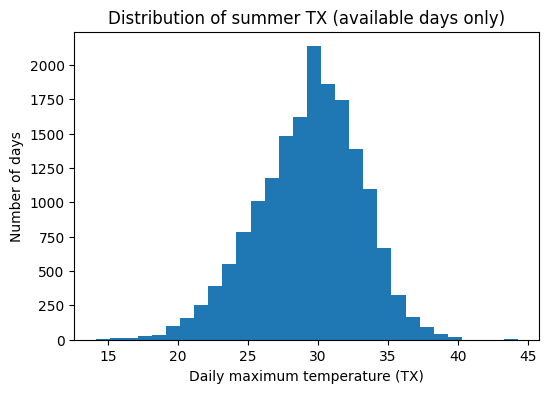

In [7]:
#df.columns

#missing too many data in "wind_mean_2m_ms"
features = [
    "wind_mean_10m_ms",
    "wind_max_hourly_ms",
    "wind_max_inst_ms",
    "wind_gust_3s_ms",
    "wind_dir_max_deg",
    "wind_dir_inst_deg"
]

target = "TX"
# Drop missing values
df_ml = df_summer[features + [target]].dropna()

X = df_ml[features]
y = df_ml[target]

print(df_summer[features + [target]].isna().sum())
print(df_summer.shape)
print(df_ml.shape)
display(df_ml.info())
display(df_ml.head())

df_ml = df_summer[features + [target]].dropna()
print(df_ml.shape)

# what is the distribution of Tx?
plt.figure(figsize=(6, 4))
plt.hist(df_ml["TX"], bins=30)
plt.xlabel("Daily maximum temperature (TX)")
plt.ylabel("Number of days")
plt.title("Distribution of summer TX (available days only)")
plt.show()



,date,NUM_POSTE,NOM_USUEL_tx,TX,TN,LAT,LON,ALTI,NOM_USUEL_wind,temp_mean_c,...,wind_max_inst_ms,wind_gust_3s_ms,wind_dir_max_deg,wind_dir_inst_deg,city,hot_day,hot_spell_len,heatwave_ge_3days,heatwave_gt_3days,month
604,1950-06-01,13047001,ISTRES,25.3,16.2,43.522667,4.927500,23,ISTRES,20.3,...,10.0,NaN,NaN,NaN,Marseille,False,0,False,False,6
605,1950-06-01,13028001,BEC DE L AIGLE,22.0,14.2,43.174667,5.574167,316,BEC DE L AIGLE,NaN,...,NaN,NaN,NaN,NaN,Marseille,False,0,False,False,6
606,1950-06-01,13103001,SALON DE PROVENCE,26.2,14.9,43.612833,5.108000,58,SALON DE PROVENCE,19.7,...,10.0,NaN,NaN,NaN,Marseille,False,0,False,False,6
607,1950-06-01,13054001,MARIGNANE,25.0,13.6,43.437667,5.216000,9,MARIGNANE,18.9,...,8.0,NaN,NaN,200.0,Marseille,False,0,False,False,6
608,1950-06-02,13054001,MARIGNANE,26.2,11.6,43.437667,5.216000,9,MARIGNANE,19.9,...,7.0,NaN,NaN,250.0,Marseille,False,0,False,False,6


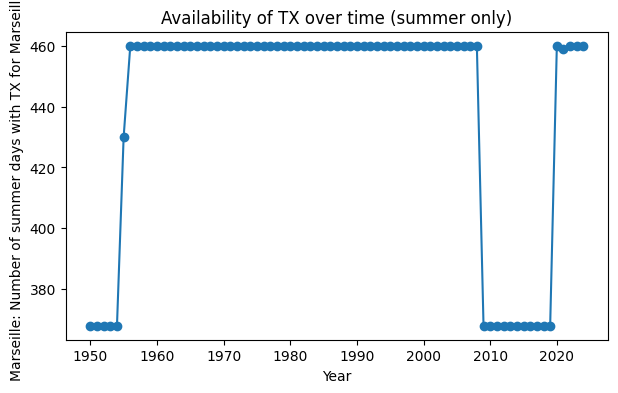

year
1950    0.000000
1951    0.000000
1952    0.000000
1953    0.000000
1954    0.000000
          ...   
2020    0.000000
2021    0.217391
2022    0.000000
2023    0.000000
2024    0.000000
Length: 75, dtype: float64


year
2009    20.0
2010    20.0
2011    20.0
2012    20.0
2013    20.0
2014    20.0
2015    20.0
2016    20.0
2017    20.0
2018    20.0
2019    20.0
dtype: float64

In [8]:
# Better understand Tx
# about 20% of the data missing for 2009-2019
# Interpretation: should not impact heavewaves too much as they are only selected
# When there are 3 days of high temperature. 
# Make sure date is datetime
display(df_summer.head())
df_summer = df_summer.copy()
df_summer["year"] = df_summer["date"].dt.year

# Count available TX per year
tx_count_per_year = (
    df_summer["TX"]
    .notna()
    .groupby(df_summer["year"])
    .sum()
)

plt.figure(figsize=(7, 4))
plt.plot(tx_count_per_year.index, tx_count_per_year.values, marker="o")
plt.xlabel("Year")
plt.ylabel("Marseille: Number of summer days with TX for Marseille")
plt.title("Availability of TX over time (summer only)")
plt.show()

# total possible summer days per year (June–Aug)
total_days_per_year = df_summer.groupby("year").size()

# available TX days per year
tx_available = df_summer["TX"].notna().groupby(df_summer["year"]).sum()

# % missing TX
tx_missing_pct = 100 * (1 - tx_available / total_days_per_year)

print(tx_missing_pct)

threshold = 10  # percent
affected_years = tx_missing_pct[tx_missing_pct > threshold]

affected_years

In [9]:



# Train / test split (NO stratify for regression)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42
)

# Model
# Regression not classifiction for continiiys TX values.
# Will use MAE, R² to eveluate. 
model = GradientBoostingRegressor(random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
results_df = pd.DataFrame([{
    "model": "Gradient Boosting (TX regression)",
    "MAE": mean_absolute_error(y_test, y_pred),
    "R2": r2_score(y_test, y_pred)
}])

display(results_df)


# Feature importance
importances = pd.Series(
    model.feature_importances_,
    index=features
).sort_values(ascending=False)


#print("Feature importance")
display(importances)

print('\n\n')
print(f"Gradient Boosting for {CITY}")


# Interpretation:
# The Gradient Boosting regression model shows moderate errors (MAE ≈ 2.8 °C)
# and low explained variance (R² ≈ 0.14), indicating that wind variables alone
# capture only a small fraction of daily maximum temperature (TX) variability.
#
# Among the wind features, wind_mean_10m_ms has the highest relative importance,
# suggesting that near-surface wind intensity is the most informative wind-related
# predictor of TX in this dataset. Wind direction variables are of secondary
# importance, likely reflecting higher variability and regime dependence.
#
# Next steps:
# 1. Reproduce for the other cities. 
#    Optional: try other models.
# 2. Add a persistence baseline (TX at t−1) to quantify the marginal contribution
#    of wind variables beyond simple temperature correlation.
# 3. If time allows: look to incorporate humidity data, which is expected to play a stronger role in
#    modulating extreme temperatures.
# 4. Beyond the scope of this work: look for data availability, extend the analysis to r
#    adiative drivers (e.g. cloud cover and incoming solar radiation) to determine their impact on 
#    the results. 
# 5. R2 =0.14 is weak


,model,MAE,R2
0,Gradient Boosting (TX regression),2.651668,0.176583


wind_mean_10m_ms      0.342950
wind_gust_3s_ms       0.223592
wind_dir_max_deg      0.142161
wind_max_hourly_ms    0.133694
wind_max_inst_ms      0.090941
wind_dir_inst_deg     0.066662
dtype: float64




Gradient Boosting for Marseille


In [10]:
# MAE -> is high 2.8 
# RSE -> can be checked